In [1]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50
from tensorflow.random import gamma as tf_random_gamma
from tensorflow import data as tf_data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import keras

#show the tensorflow version
print(tf.__version__)

2.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1356227998239291204
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5424111420556128827
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0
# Convert data to one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [4]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 40

## Mixup Method Regularization

In [5]:

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))


test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [6]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]  # Use tf instead of keras

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Cast the lambda tensors to the same data type as the images tensors
    x_l = tf.cast(x_l, images_one.dtype)
    y_l = tf.cast(y_l, labels_one.dtype)

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)



[0.0, 0.0, 0.0, 0.0, 0.3775019645690918, 0.0, 0.0, 0.0, 0.6224980354309082, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9635639786720276, 0.03643599897623062, 0.0, 0.0]
[0.5475035309791565, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4524964690208435]
[0.0, 0.0444258451461792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9555741548538208]
[0.0, 0.0, 0.11641144007444382, 0.0, 0.0, 0.0, 0.0, 0.8835885524749756, 0.0, 0.0]
[0.0, 0.8905543684959412, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10944562405347824, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8392398357391357, 0.16076016426086426, 0.0, 0.0]
[0.0, 0.8523390889167786, 0.0, 0.0, 0.14766089618206024, 0.0, 0.0, 0.0, 0.0, 0.0]


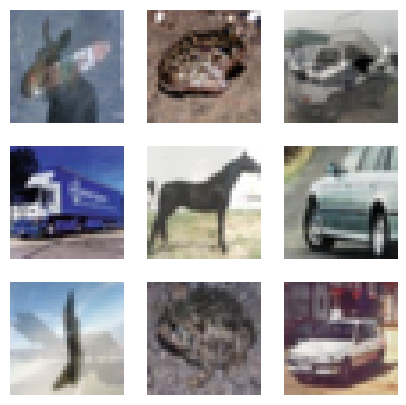

In [11]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)


# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(5, 5))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [ ]:
# !nvidia-smi --query-gpu=memory.total --format=csv

memory.total [MiB]
23034 MiB


## Model

In [12]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

### Mixup Model Training

Epoch 1/40
782/782 [==============================] - 11s 9ms/step - loss: 1.6916 - accuracy: 0.4076 - val_loss: 1.1519 - val_accuracy: 0.5862
Epoch 2/40
782/782 [==============================] - 6s 8ms/step - loss: 1.2667 - accuracy: 0.6096 - val_loss: 0.9678 - val_accuracy: 0.6655
Epoch 3/40
782/782 [==============================] - 6s 7ms/step - loss: 1.0935 - accuracy: 0.6929 - val_loss: 0.8536 - val_accuracy: 0.7015
Epoch 4/40
782/782 [==============================] - 6s 7ms/step - loss: 0.9951 - accuracy: 0.7370 - val_loss: 0.7913 - val_accuracy: 0.7373
Epoch 5/40
782/782 [==============================] - 6s 7ms/step - loss: 0.9202 - accuracy: 0.7681 - val_loss: 0.7881 - val_accuracy: 0.7324
Epoch 6/40
782/782 [==============================] - 6s 7ms/step - loss: 0.8735 - accuracy: 0.7886 - val_loss: 0.7392 - val_accuracy: 0.7572
Epoch 7/40
782/782 [==============================] - 6s 7ms/step - loss: 0.8156 - accuracy: 0.8118 - val_loss: 0.7139 - val_accuracy: 0.7688
Epoch

<Figure size 1000x1000 with 0 Axes>

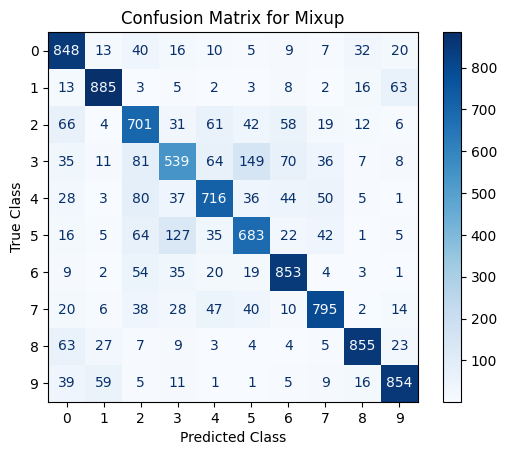

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_ds_mu, validation_data=test_ds, epochs=EPOCHS, callbacks=[tensorboard_callback])
train_loss = history.history['loss']
val_loss = history.history['val_loss']

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy {}'.format(test_acc))
# Prediction
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Mixup')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [14]:
#Evaluate the model
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

157/157 [==============================] - 1s 3ms/step - loss: 0.8095 - accuracy: 0.7729
Test accuracy: 77.29%


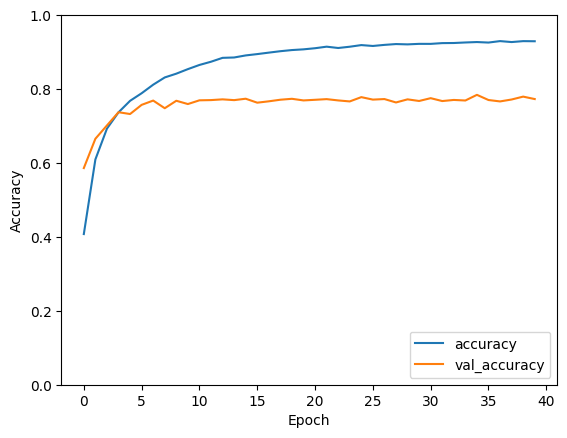

In [15]:
#Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

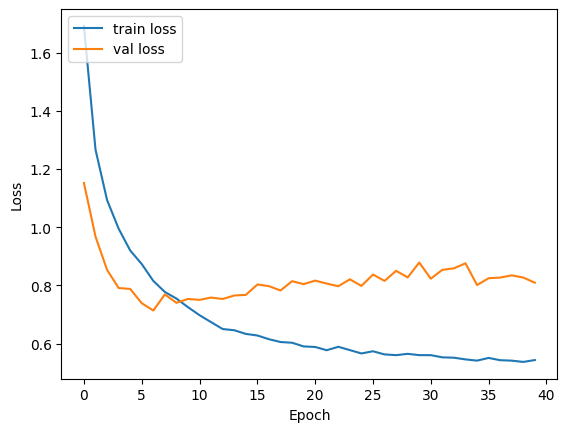

In [16]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper left')
#show plot
plt.show()

In [17]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn_mixup.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights_mixup.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from google.colab import files
files.download("/content/logs")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>